In [3]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-08-10 20:32:20.415577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 20:32:20.466152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 20:32:20.466975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 20:32:21.238291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [5]:
zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

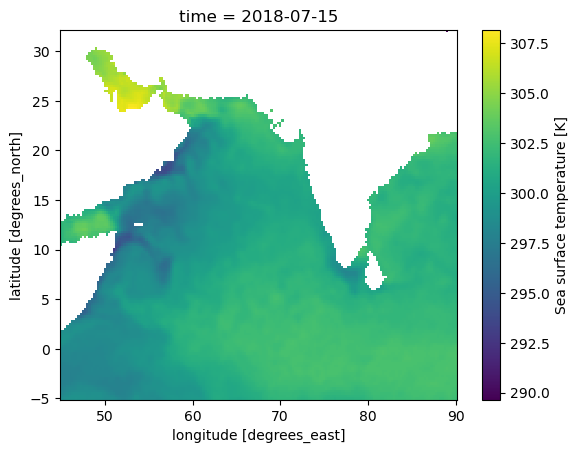

In [17]:
p = zarr_new.sel(time='2018-07-15').sst.plot(y='lat', x='lon')
plt.savefig('2018-07-15.png')
plt.show()

In [5]:
def create_data_map(variable_name, start_date='2010-01-01', end_date='2022-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1983-04-01', end='1983-04-30'),
        pd.date_range(start='1988-02-01', end='1988-02-29'),  # February in a leap year
        pd.date_range(start='1992-09-01', end='1992-09-30'),
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30'),
        pd.date_range(start='2006-04-01', end='2006-04-30'),
        pd.date_range(start='2011-02-01', end='2011-02-28'),
        pd.date_range(start='2015-06-01', end='2015-06-30'),
        pd.date_range(start='2020-02-01', end='2020-02-29')  # February in a leap year
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('CHL')

In [6]:
sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)
input_shape

(149, 181, 1)

In [7]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2010-01-01', '2022-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201001_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201002_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201003_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201004_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201005_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201006_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201007_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201008_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201009_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201010_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [8]:
valid_dates = list(data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]

assert len(data_map) == len(filtered_labels)

In [9]:
all_labels_reshaped = filtered_labels.values.ravel()

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = np.array(list(data_map.values()))

X = np.expand_dims(X, axis=-1)

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, all_labels_reshaped, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 for validation

sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)

base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback, early_stopping_callback], validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

29/29 [==============================] - 6s 194ms/step - loss: 0.1349 - accuracy: 0.9588
Accuracy: 0.958751380443573


In [11]:
pip install lime

  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached scikit_image-0.21.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.8 MB)
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step
[[0.9988273 0.0011727]]


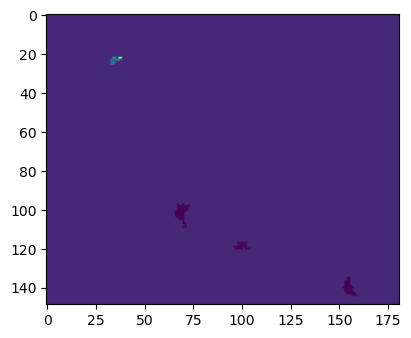

In [13]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

def predict_fn(data):
    proba_1 = model.predict(data)
    proba_0 = 1 - proba_1
    return np.hstack([proba_0, proba_1])

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2, convert2lab=False)
explanation = explainer.explain_instance(X_test[5], predict_fn, 
                                         top_labels=2,
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn=segmenter)

print(predict_fn(X_test[0:1]))

temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(temp)


In [27]:
background_data.shape

(100, 149, 181, 1)

In [38]:
import pickle
with open('/home/jovyan/shared/jiarui-notebooks/sampled_points_50km.pickle', 'rb') as handle:
    sampled_points_50km = pickle.load(handle)

with open('/home/jovyan/shared/jiarui-notebooks/nearest_points.pickle', 'rb') as handle1:
    nearest_points = pickle.load(handle1)

In [40]:
type(sampled_points_50km)

geopandas.geodataframe.GeoDataFrame